# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [10]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [11]:

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

In [12]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [13]:
l2_reg = 1.0
shift_cost = 1.0
result_dir = "../results"
base = "/home/hp/pai/check1/prospect/experiments/results"
obj_names = ["CVaR", "ESRM"]

In [14]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
        "epsilon":4,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=2",
        "color": "yellow",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":2,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=4",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":4,
    },

    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=8",
        "color": "blue",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":8,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=16",
        "color": "green",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":16,
    },
        {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=1024",
        "color": "pink",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":1024,
    },
]

In [15]:
def get_mypath(base_dir,model_cfg,datset,specific_cfg):
    path1 = get_path([datset,var_to_str(model_cfg),var_to_str(specific_cfg)],base_dir)
    return path1

def get_mypath2(base_dir,model_cfg,datset):
    path1 = get_path([datset,var_to_str(model_cfg)],base_dir)
    return path1


In [16]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def get_iterates(dataset,objective  ,optimizer, seed=1, result_dir=None):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        "shift_cost": shift_cost
    }
    best_path = get_mypath2(result_dir,model_cfg=model_cfg,datset=dataset)
    best_path = os.path.join(best_path,optimizer+"/best_cfg.p")
    specific_cfg = None
    with open(best_path, 'rb') as file:
        specific_cfg = pickle.load(file)
    print("objective",objective,"specific_cfg",specific_cfg)
    path = get_mypath(datset=dataset,model_cfg=model_cfg,base_dir=result_dir,specific_cfg=specific_cfg)
    f = os.path.join(path, f"seed_{seed}.p")
    data = pickle.load(open(f, "rb"))
    metrics_data = data['metrics']    
    return metrics_data['weights']


def get_dp(X,y,dataset,column, objective,optimizer, metric="difference",df=None,base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        if i>=0:
            y_pred = (X @ w >= 0).int()
            if metric == "difference":
                out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
            elif metric == "ratio":
                out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(X,df,column, optimizer, objective, dataset, method="ks",base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    groups = list(df[column].unique())
    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        if i>0:
            y_pred = (X @ w).detach().numpy()
            ypd = pd.Series(y_pred)
            y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
            if method == "ks":
                dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
            elif method == "wasserstein":
                raise Exception("Wasserstein not defined!")

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

Suboptimality 

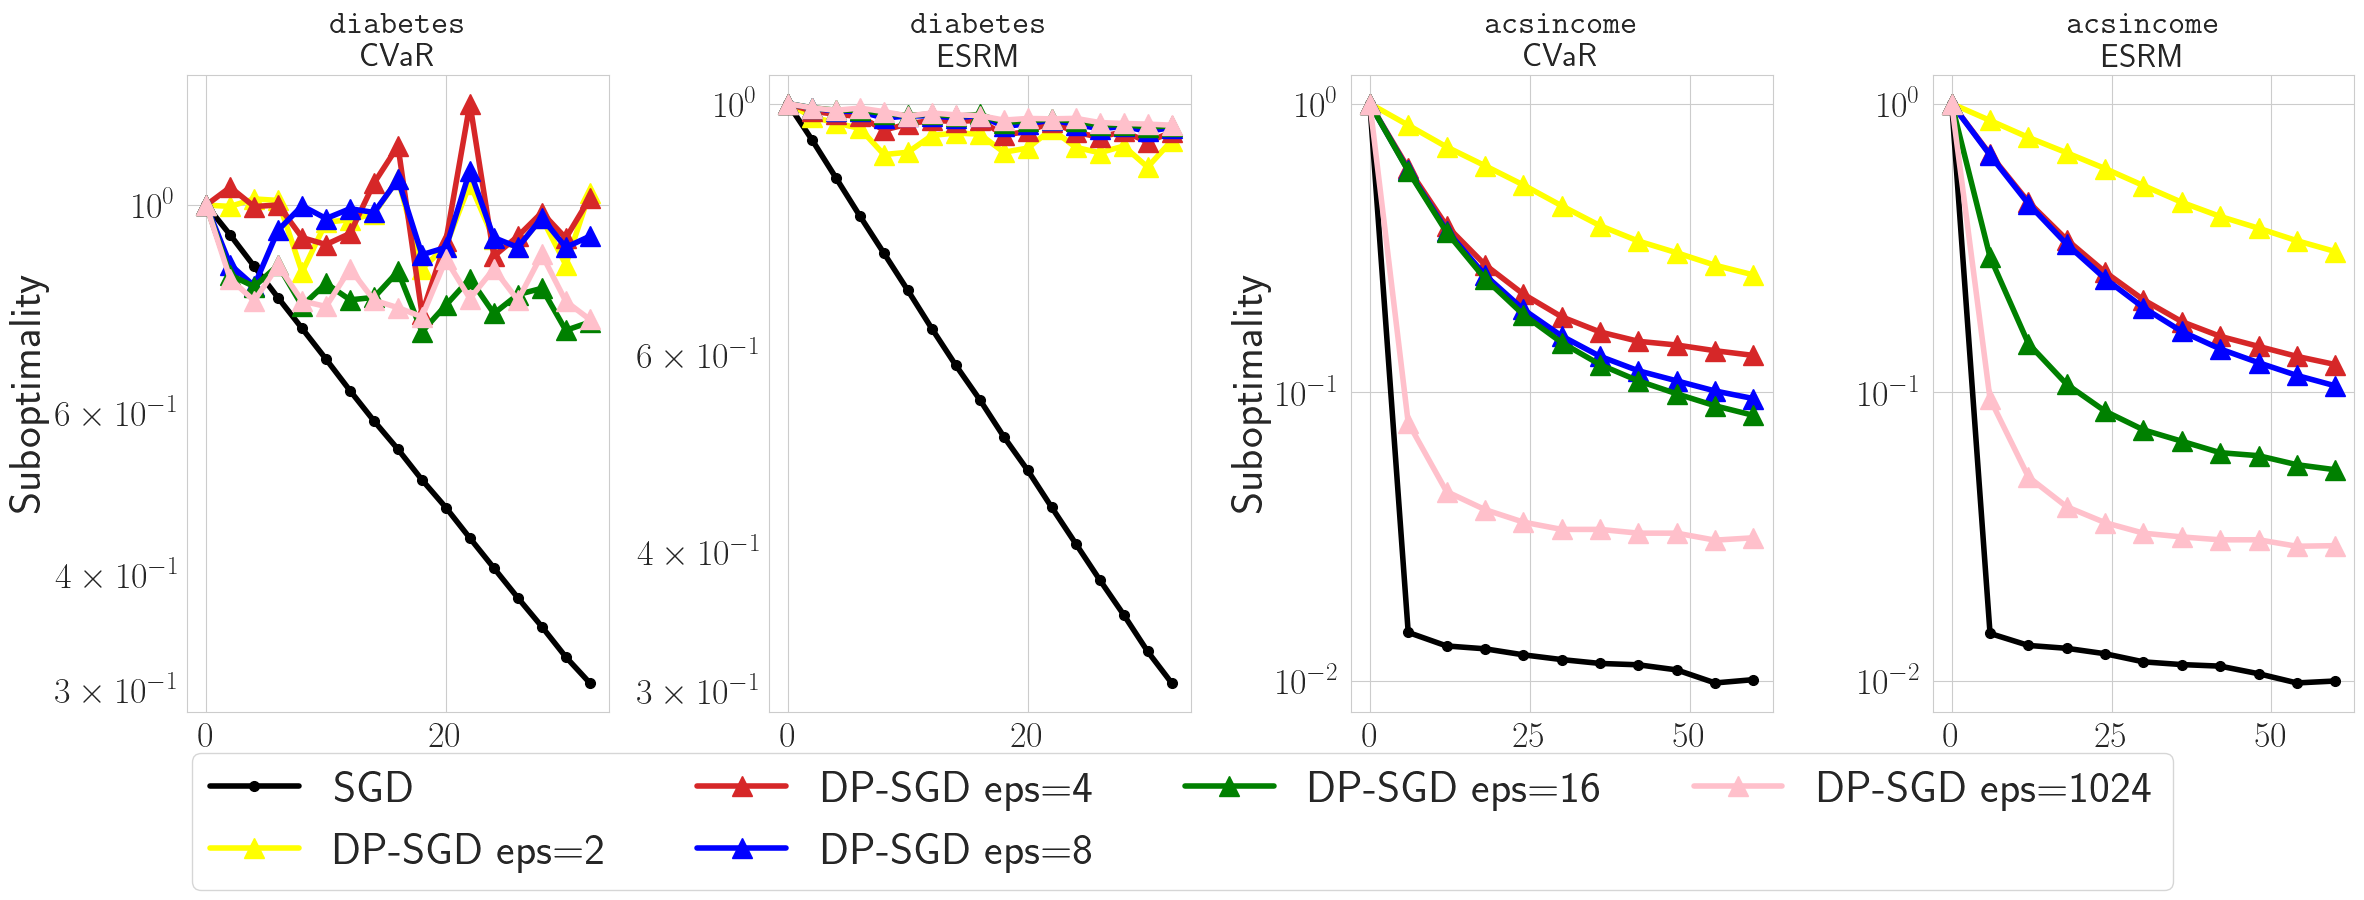

In [17]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]


sns.set_style("whitegrid")

fig, ax = plt.subplots(1, len(objectives) * 2, figsize=(12 * len(objectives), 8))

for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")
        markersize = 14
        downsample = 2
        ax[j].set_title(r"{\texttt{diabetes}} " + f"\n{obj_names[j]}", fontsize=24)
        plot_ax(ax[ j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=path)
        ax[j].set_yscale("log")
        
ax[0].set_ylabel(f"Suboptimality", fontsize=32)

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]


for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]   
        path = os.path.join(base + f"_{float(epsilon):.6f}")
        markersize = 14
        downsample = 6
        ax[j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        plot_ax(ax[ j+2], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize,out_path=path)
        ax[j+2].set_yscale("log")
            
ax[ 2].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

Demographic Parity - Gender

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 87.58it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 73.84it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 79.65it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 75.01it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 85.38it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 83.96it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 77.39it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 91.02it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 78.47it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 76.64it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 90.77it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 94.12it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 93.83it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 89.10it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 97.62it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 89.51it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 89.81it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 85.37it/s] 


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 103.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 113.09it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 90.66it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 112.40it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 113.21it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 112.65it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 101.11it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 106.07it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 103.48it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 106.58it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 95.55it/s] 


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 100.03it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 98.34it/s] 


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 105.30it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 104.36it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 106.43it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 102.26it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 99.72it/s] 


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 93.09it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 91.55it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 91.36it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 91.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 104.44it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 102.66it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 107.53it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 106.10it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 102.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 87.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 94.24it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 84.30it/s]


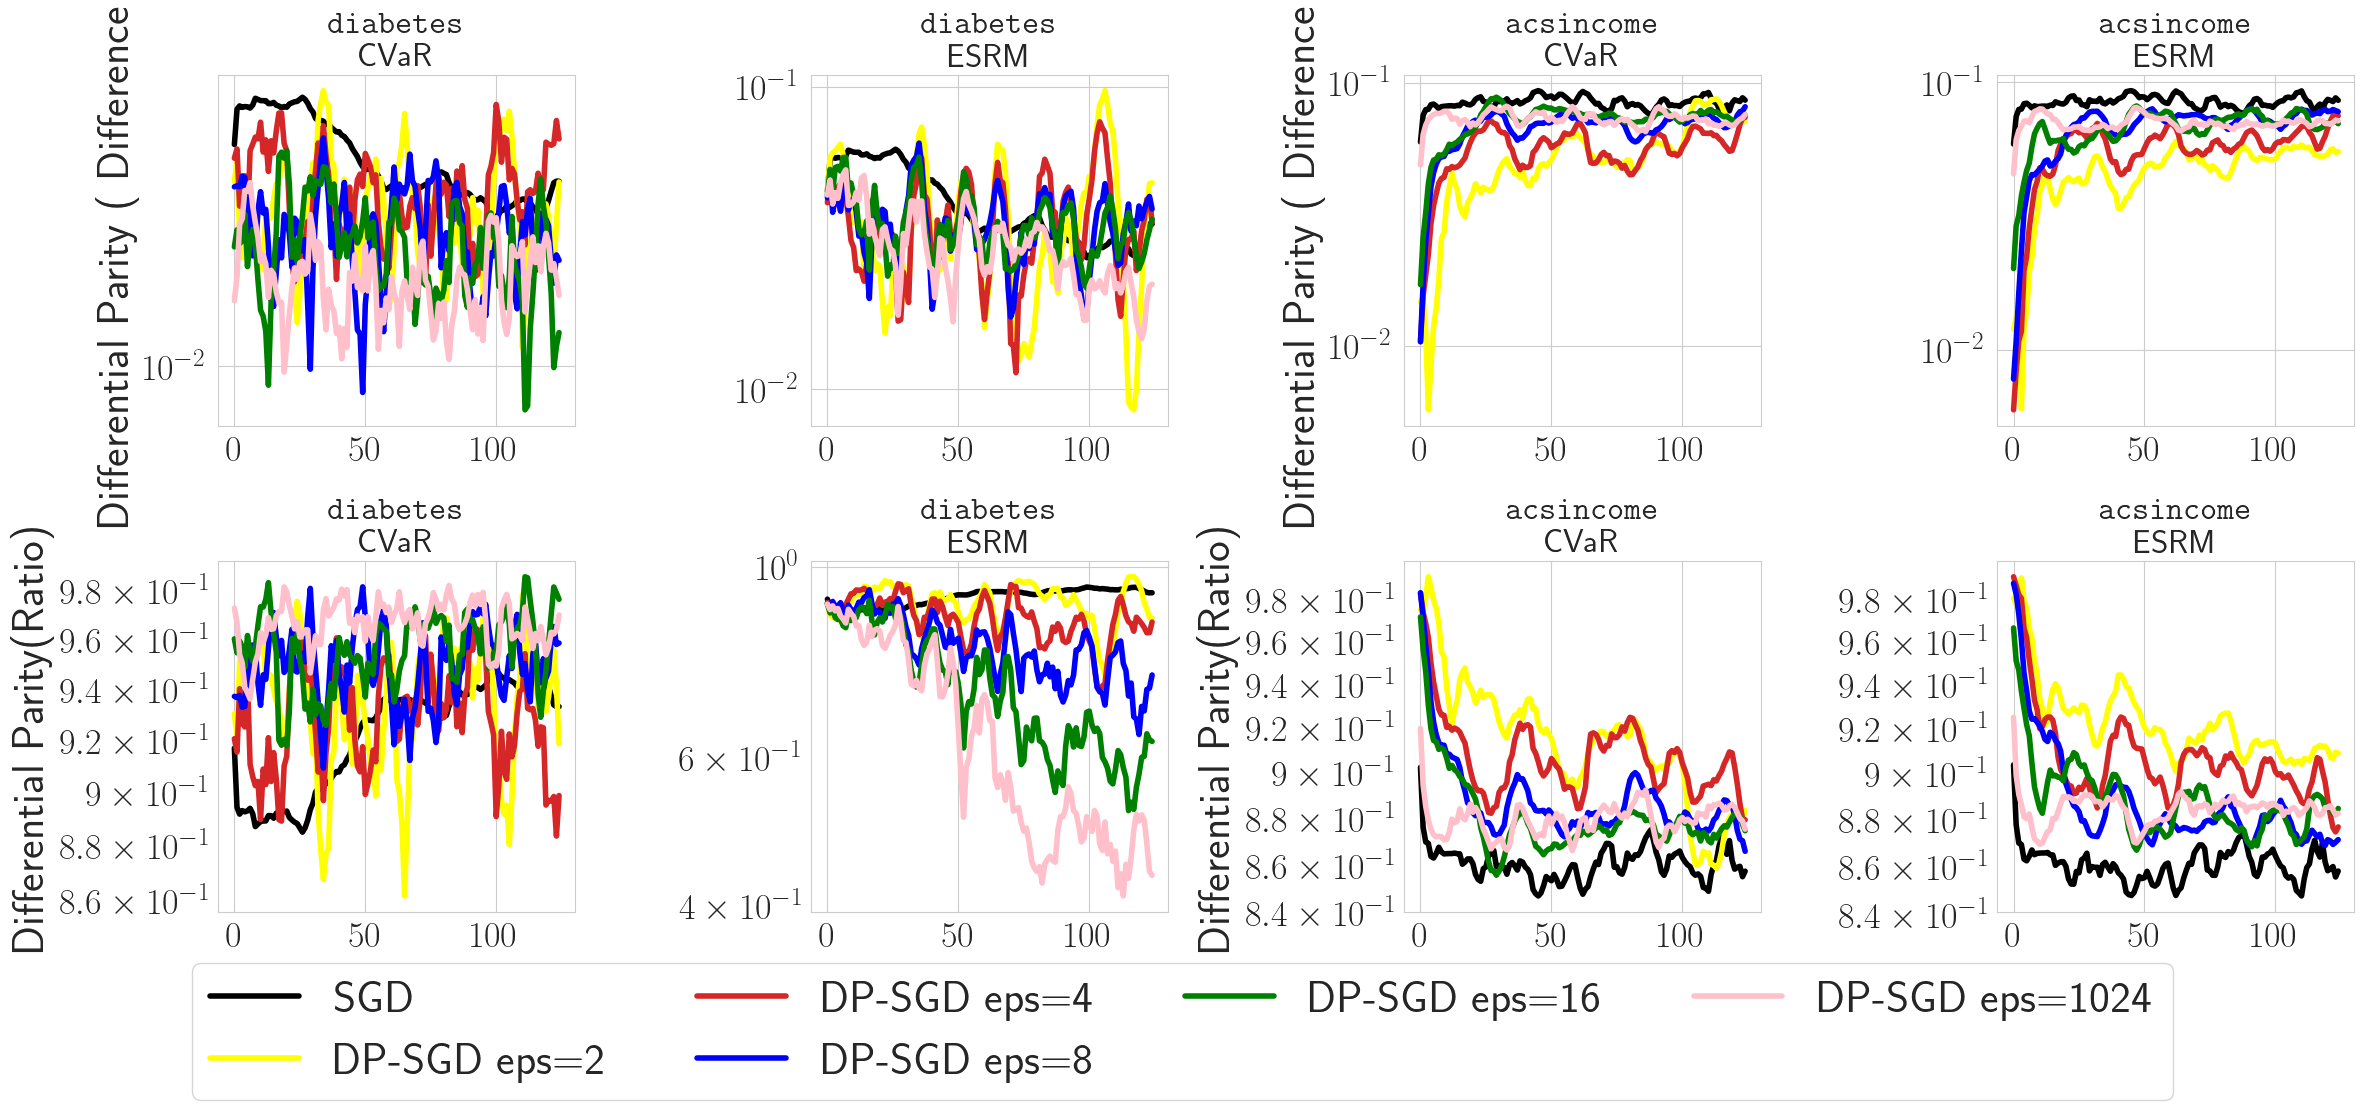

In [18]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "gender"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Differential Parity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Differential Parity(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "SEX"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Differential Parity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Differential Parity(Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

Demographic Parity - Race

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 81.46it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 93.48it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 88.33it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 75.05it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 80.22it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 65.80it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 100.18it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 100.01it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 95.39it/s] 


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 96.26it/s] 


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 80.13it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 87.92it/s] 


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 105.20it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 102.78it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 96.73it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 80.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 104.38it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 81.52it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 95.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 102.08it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 101.37it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 95.75it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 77.93it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 103.87it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 97.21it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 97.48it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 92.54it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 96.38it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 93.95it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 84.32it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 92.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 90.73it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 92.97it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 91.25it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 92.08it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 95.90it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 96.21it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 92.98it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 96.39it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 92.82it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 93.69it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 97.38it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 95.42it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 98.16it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 87.20it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 88.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 89.41it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 94.35it/s]


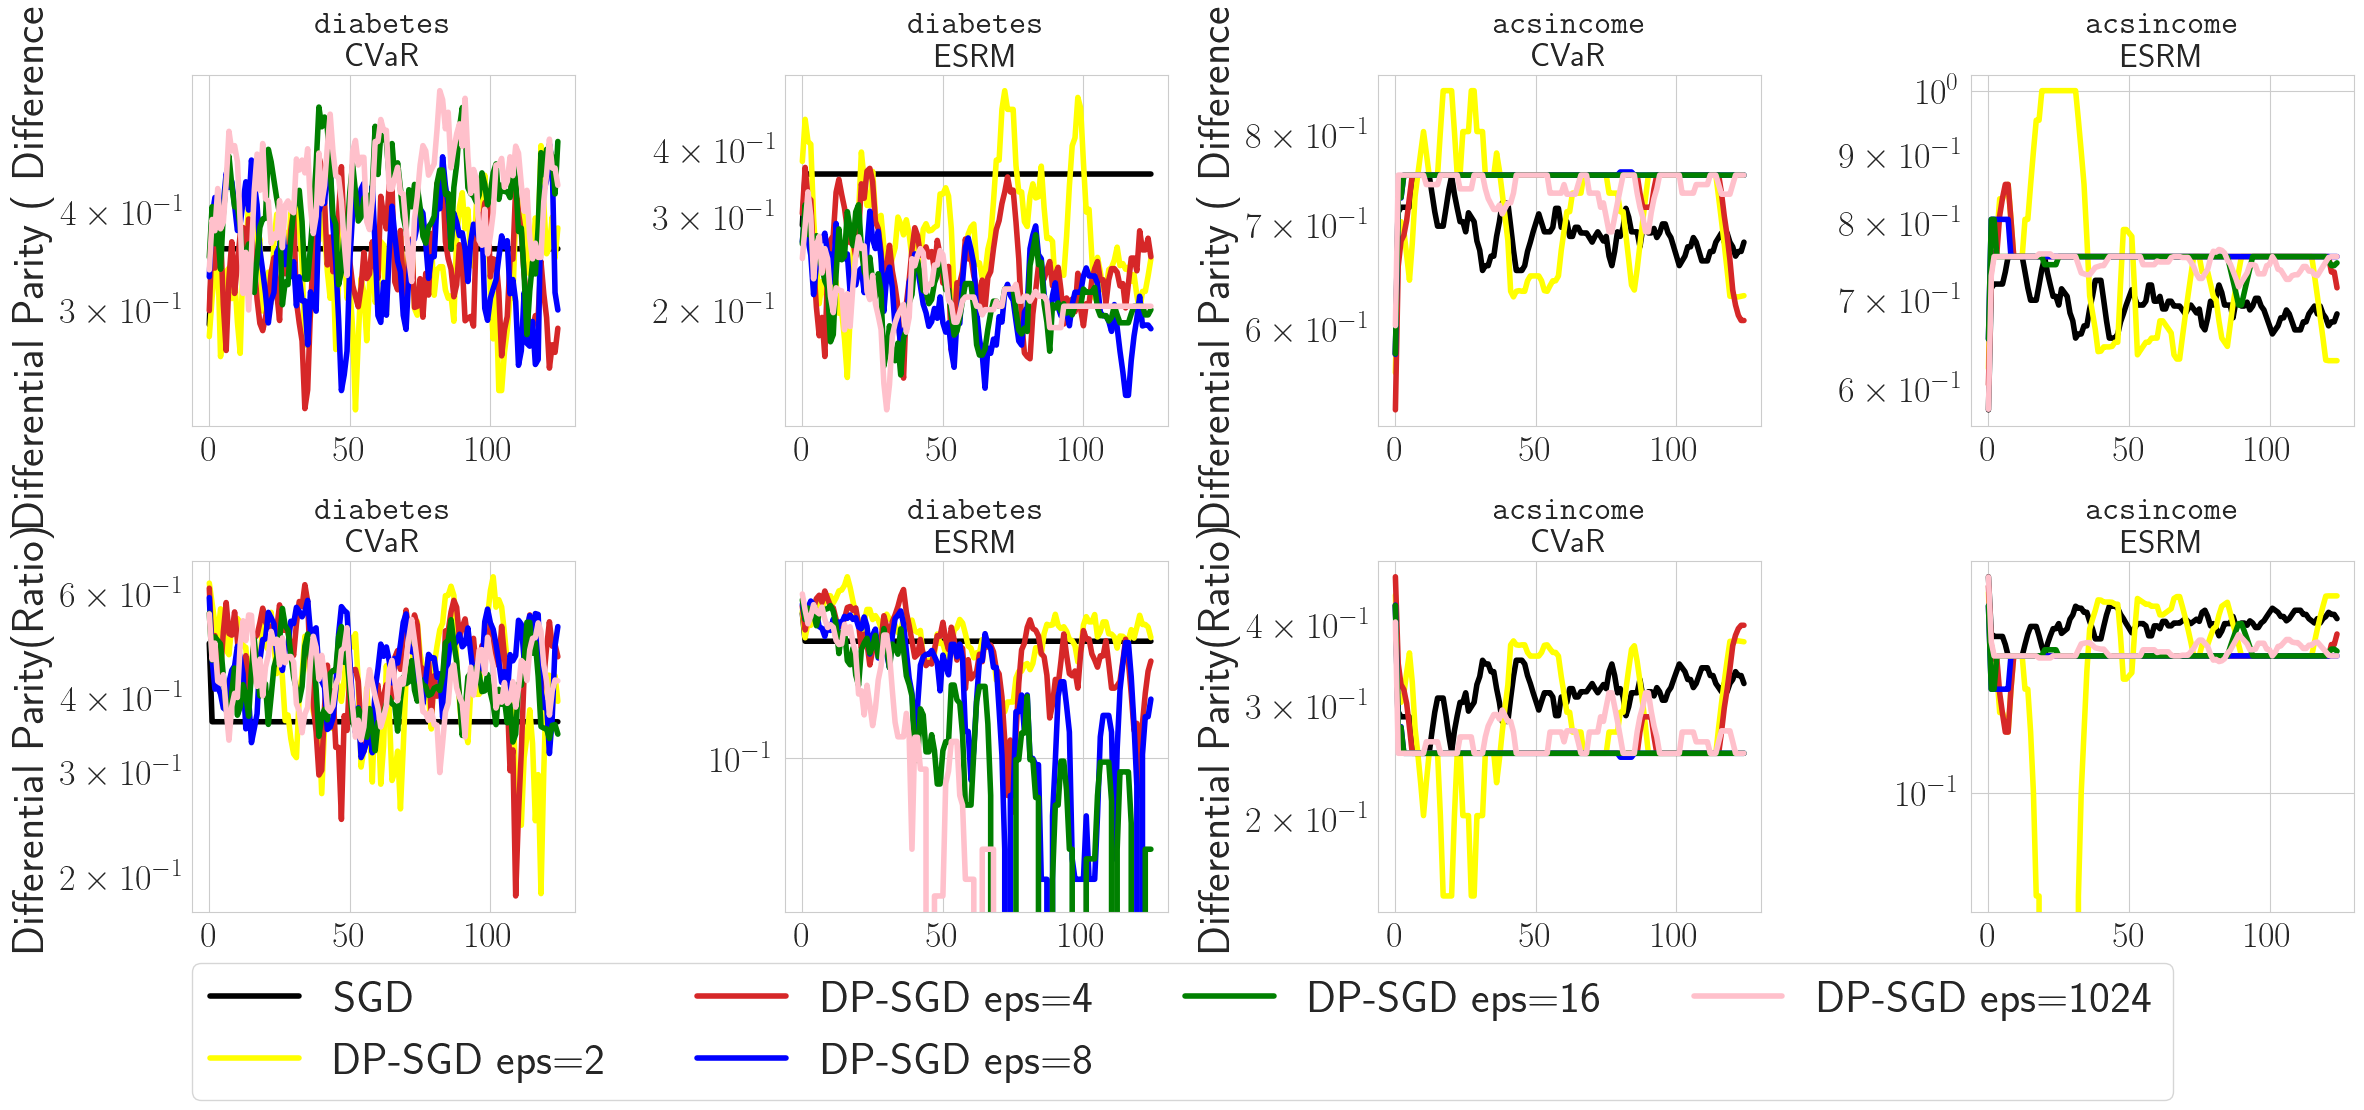

In [19]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "race"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Differential Parity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Differential Parity(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "RAC1P"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Differential Parity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df,base_dir=path)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Differential Parity(Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

 distributional differences between predicted outcomes across different demographic groups using statistical tests ( the Kolmogorov-Smirnov test). - Gender and race

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 482.18it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 419.36it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 470.74it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 630.13it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 475.34it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 516.72it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 817.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 490.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 717.70it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 566.80it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 468.94it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 638.82it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 197.52it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 274.77it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 269.76it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 153.06it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 147.10it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 150.55it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 248.95it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 279.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 286.32it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 291.99it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 285.09it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 200.23it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 595.91it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 667.75it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 564.89it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 528.11it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 537.43it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 906.67it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 935.70it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 849.01it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 794.34it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 809.23it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 510.60it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 811.34it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 226.87it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 202.54it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 131.47it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 216.71it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 126.62it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:00, 231.14it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:00, 210.83it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:00, 199.33it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 114.58it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:00, 203.09it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:00, 221.44it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 118.68it/s]


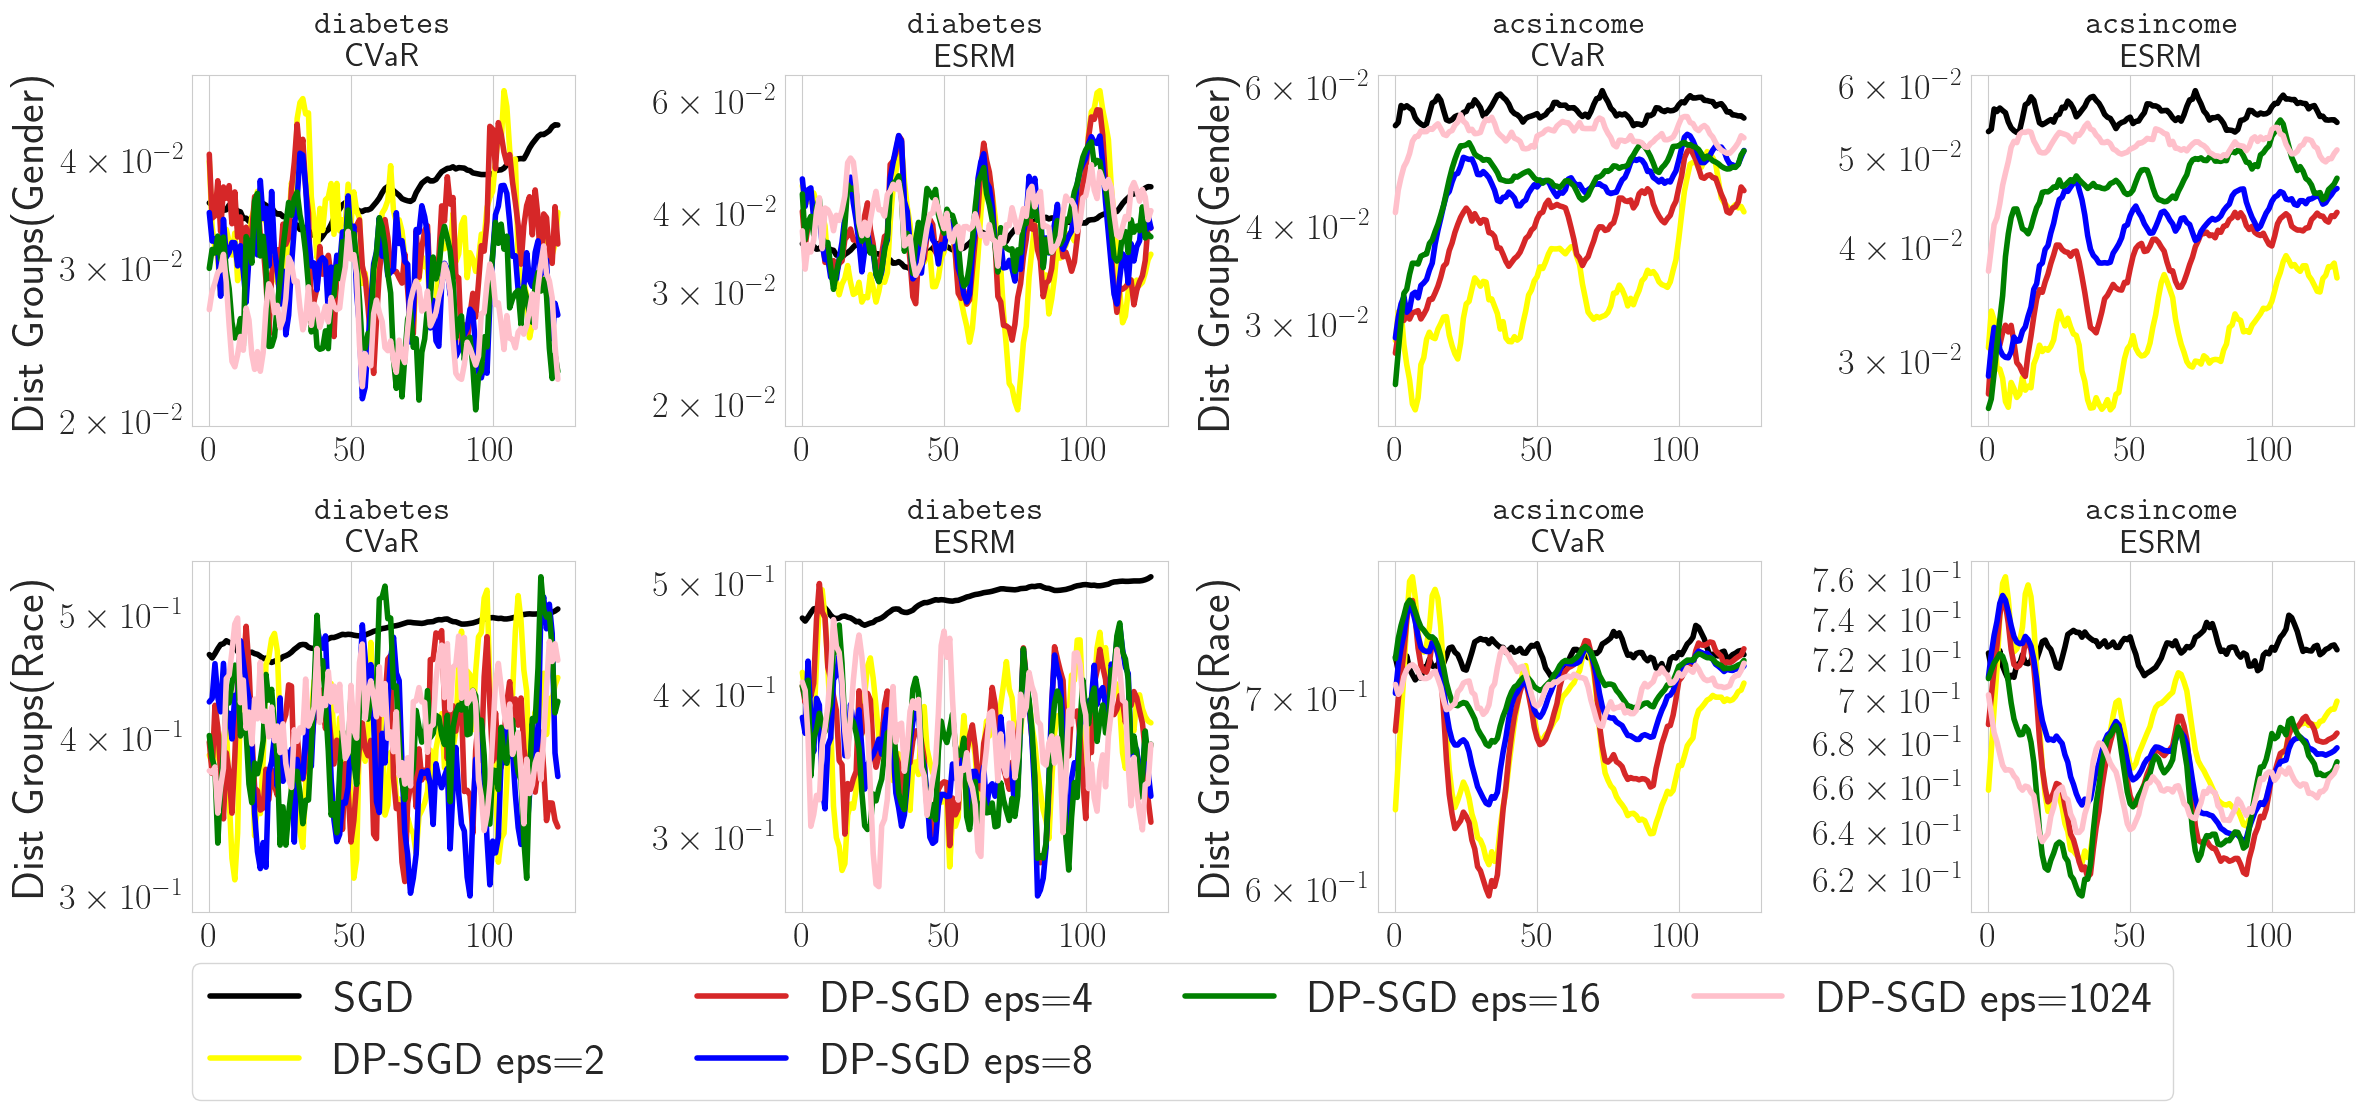

In [20]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "gender"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        group_loss = get_dist_groups(X,df,column, optimizer, objective,dataset=dataset,base_dir=path)
        yy = np.max(group_loss, axis=1) # worst distance
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Dist Groups(Gender)", fontsize=32)


column = "race"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        group_loss = get_dist_groups(X,df,column, optimizer, objective,dataset=dataset,base_dir=path)
        yy = np.max(group_loss, axis=1) # worst distance
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))

        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Dist Groups(Race)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "SEX"

for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        group_loss = get_dist_groups(X,df,column, optimizer, objective,dataset=dataset,base_dir=path)
        yy = np.max(group_loss, axis=1) # worst distance
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))

        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Dist Groups(Gender)", fontsize=32)


column = "RAC1P"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        group_loss = get_dist_groups(X,df,column, optimizer, objective,dataset=dataset,base_dir=path)
        yy = np.max(group_loss, axis=1) # worst distance
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Dist Groups(Race)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

In [21]:
from fairlearn.metrics import equalized_odds_difference,equalized_odds_ratio

def get_equalized_odds(X,y,dataset,column, objective,optimizer, metric="difference",df=None,base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    out = []
    # y = y.int().numpy()
    y = np.clip(y.int().numpy(), 0, 1).astype(int)
    for i, w in tqdm(enumerate(iterates)):
        if i>=0:
            # y_pred = (X @ w >= 0).int().numpy()
            y_pred = np.clip((X @ w >= 0).int().numpy(), 0, 1).astype(int)

            # Ensure y_pred and y are binary (0/1)
            # y_pred = np.clip(y_pred, 0, 1).astype(int)  # Clip to ensure values are either 0 or 1
            # y = np.clip(y, 0, 1).astype(int)  
            # if i==0:
            #     print("y",y,"y_pred",y_pred)
            if metric == "difference":
                out.append(equalized_odds_difference(y, y_pred, sensitive_features=list(df[column])))
            elif metric == "ratio":
                out.append(equalized_odds_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

Equalized Odds Gender

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 70.91it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 74.32it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 70.05it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 73.16it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 70.86it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 82.11it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 75.81it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 85.09it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 90.19it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 89.94it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 80.24it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 86.52it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 88.63it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 81.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 83.85it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 73.60it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 82.90it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 87.73it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 89.44it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 83.86it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 82.22it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 84.99it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 83.82it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 84.86it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 75.34it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 81.17it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 85.93it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 81.66it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 86.50it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 78.53it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 86.35it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 81.02it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 82.82it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 85.68it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 83.49it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 86.59it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 86.63it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 84.95it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 80.25it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 78.34it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 71.32it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 74.90it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 85.79it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 85.13it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 85.31it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 86.22it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 84.41it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 79.04it/s]


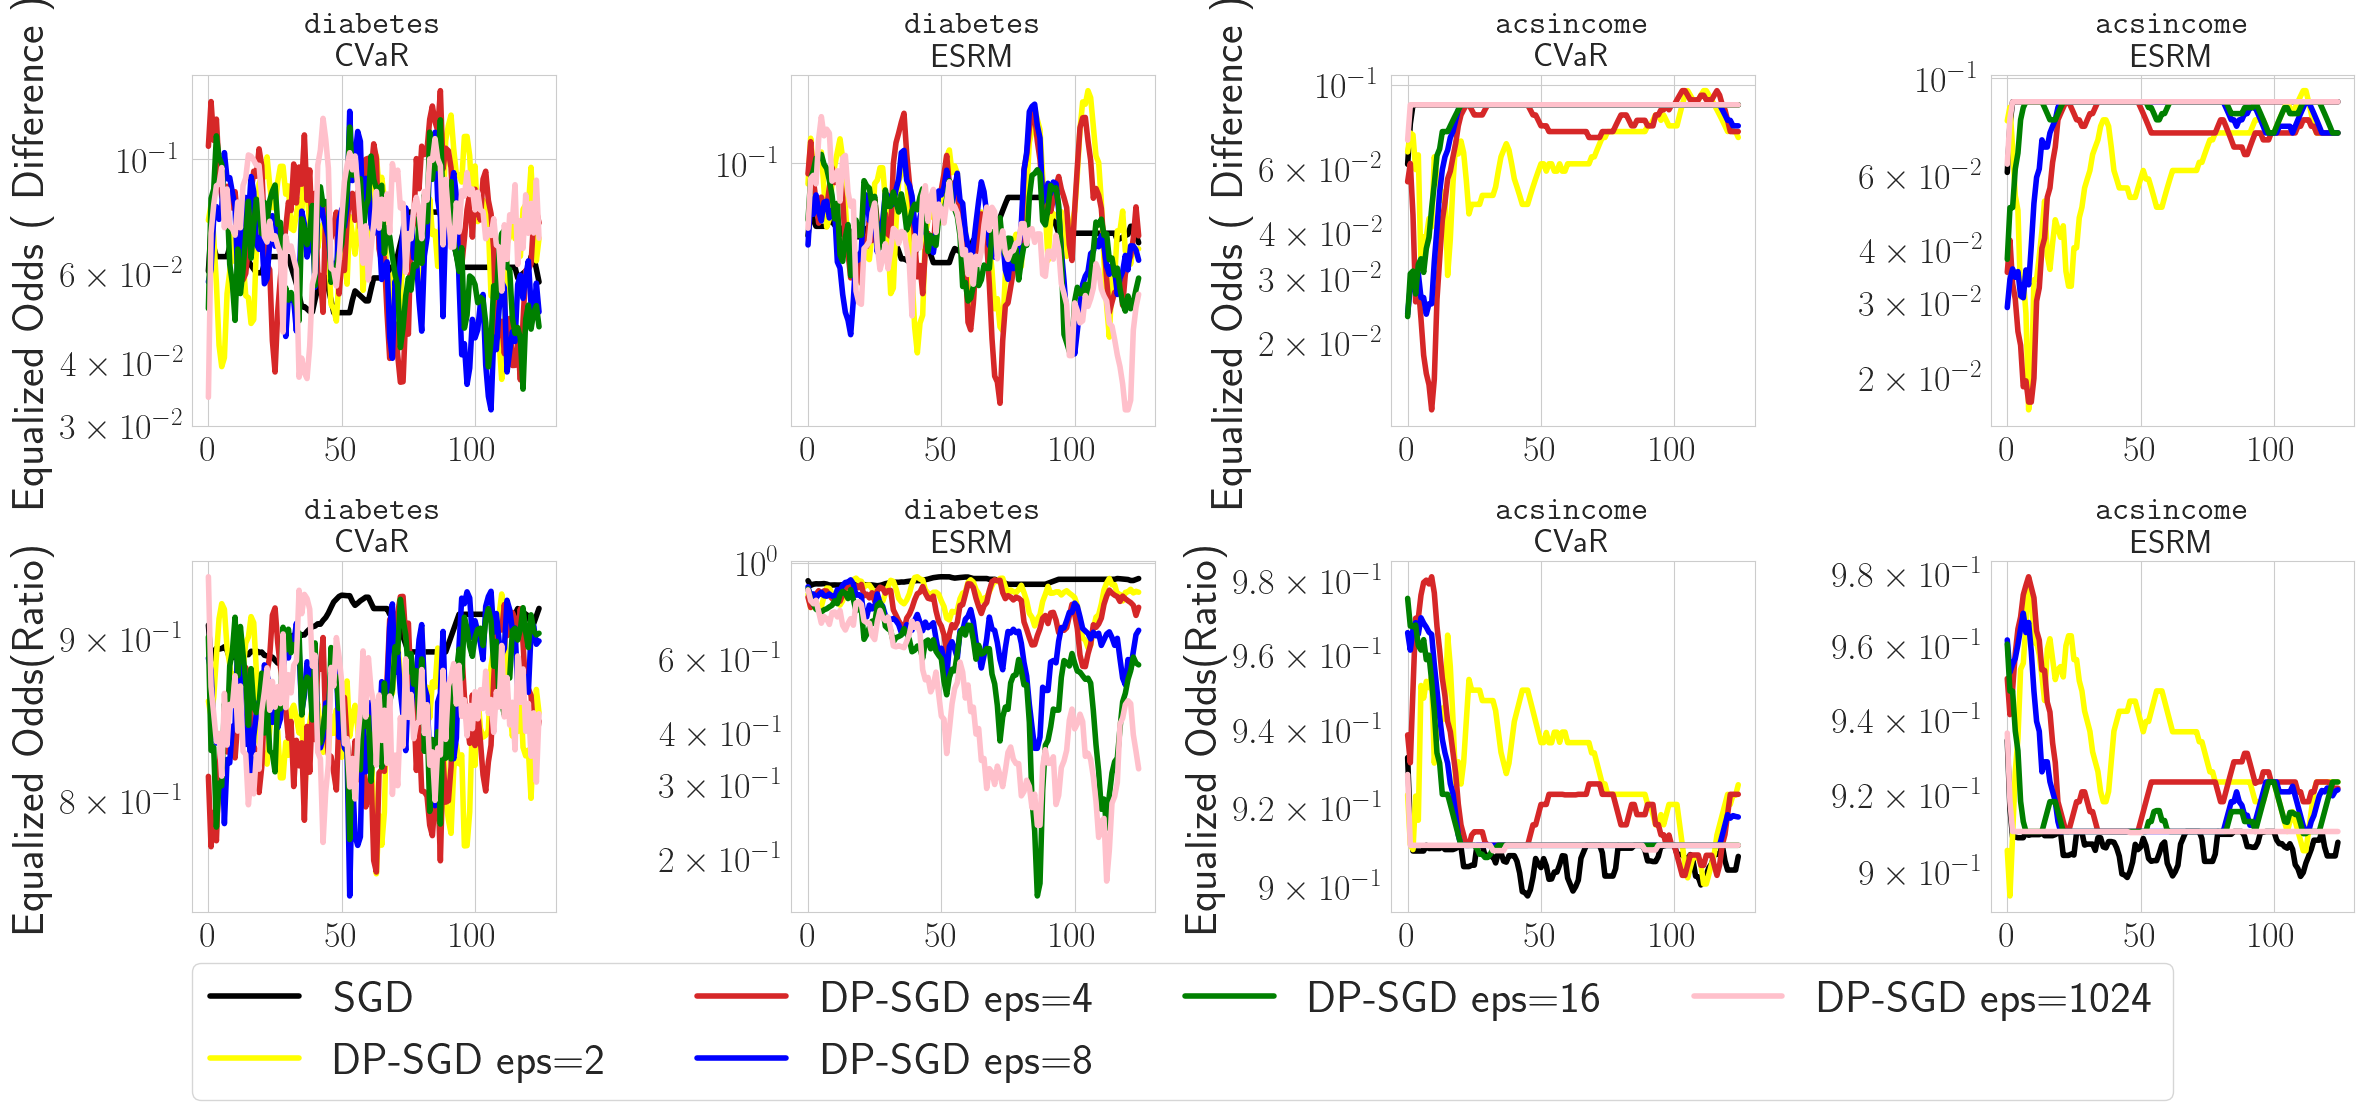

In [22]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "gender"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Equalized Odds ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Equalized Odds(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "SEX"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Equalized Odds ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Equalized Odds(Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

Equalized Odds Race

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 61.36it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 58.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 52.98it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 56.78it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 63.51it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 69.68it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 67.21it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 60.93it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 69.82it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 69.70it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 66.17it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 63.33it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 69.34it/s]
/tmp/ipykernel_276947/2205614284.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j].set_yscale("log")


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 65.47it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 68.11it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 67.44it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 69.36it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 69.77it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 69.83it/s]
/tmp/ipykernel_276947/2205614284.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j].set_yscale("log")


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 68.63it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 62.32it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 64.30it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 65.77it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 65.96it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 59.40it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 59.92it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 60.57it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 51.03it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 57.11it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 58.70it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 57.78it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 59.67it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 59.78it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 55.11it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 56.18it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 60.12it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 53.89it/s]
/tmp/ipykernel_276947/2205614284.py:116: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j+2].set_yscale("log")


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 52.04it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 53.41it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 52.18it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 58.53it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 64.77it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 63.94it/s]
/tmp/ipykernel_276947/2205614284.py:116: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j+2].set_yscale("log")


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 64.82it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 66.47it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 66.58it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 66.58it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 66.87it/s]
/tmp/ipykernel_276947/2205614284.py:121: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(pad=2.0)


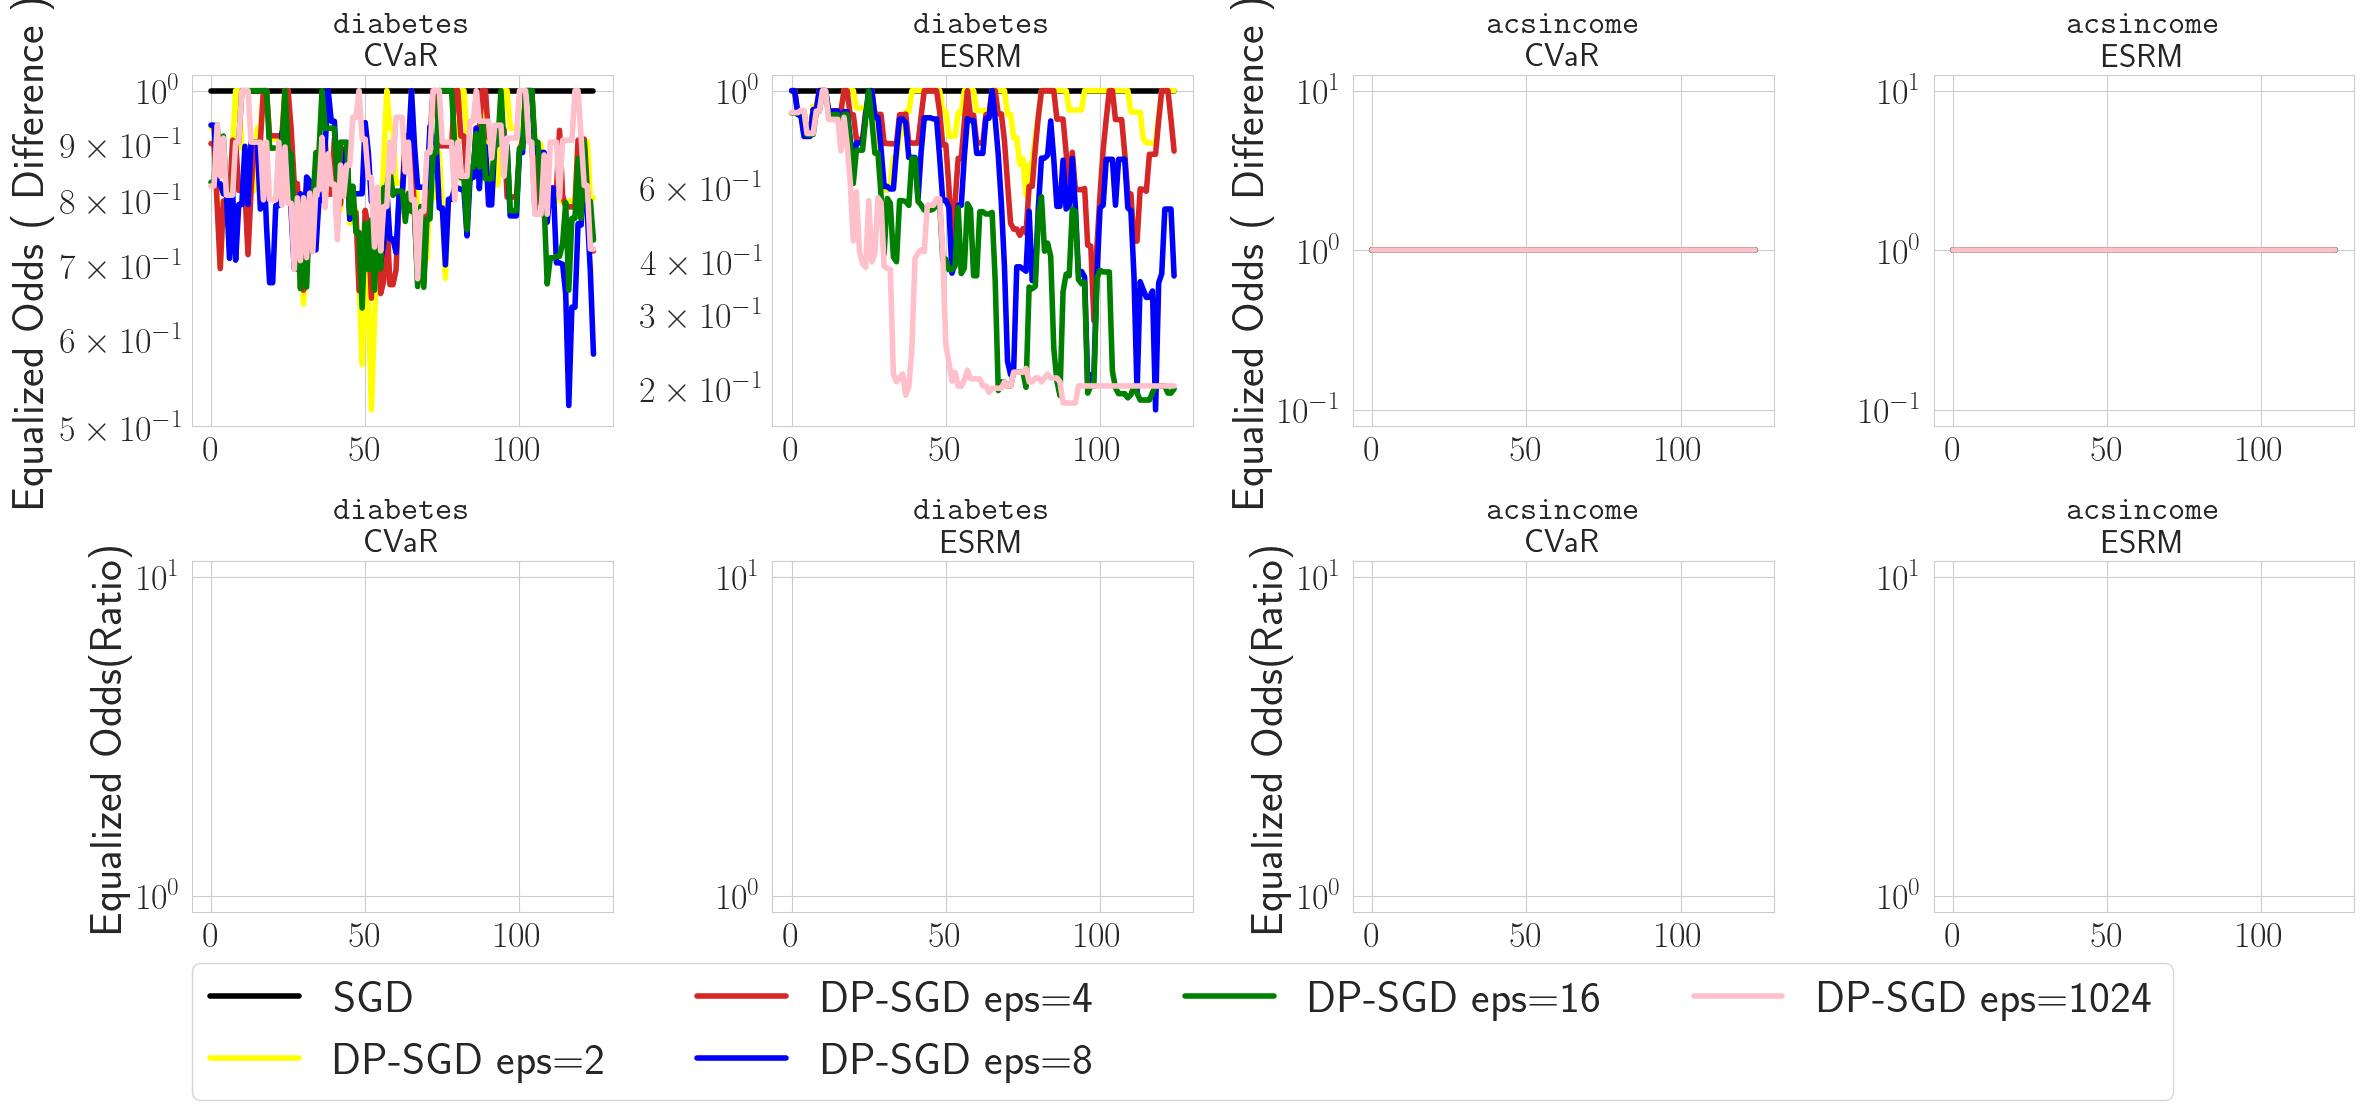

In [23]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "race"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Equalized Odds ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Equalized Odds(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "RAC1P"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Equalized Odds ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_odds(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Equalized Odds(Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

Equal Opportunity

In [24]:
from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

def get_equalized_opportunity(X,y,dataset,column, objective,optimizer, metric,df=None,base_dir=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    out = []
    # y = y.int().numpy()
    y = np.clip(y.int().numpy(), 0, 1).astype(int)
    for i, w in tqdm(enumerate(iterates)):
        if i>=0:
            # y_pred = (X @ w >= 0).int().numpy()
            y_pred = np.clip((X @ w >= 0).int().numpy(), 0, 1).astype(int)
            if metric == "difference":
                out.append(equal_opportunity_difference(y, y_pred, sensitive_features=list(df[column])))
            elif metric == "ratio":
                out.append(equal_opportunity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

Equal Opportunity Gender

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 77.55it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 79.35it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 81.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 72.00it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 79.33it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 61.40it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 82.14it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 81.48it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 73.54it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 83.99it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 86.61it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 92.40it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 85.99it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 83.27it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 68.81it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 70.67it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 81.74it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 73.18it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 76.29it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 69.65it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 77.76it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 77.07it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 73.80it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 81.07it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 69.45it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 76.47it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 80.27it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 76.19it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 74.84it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 65.63it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 70.74it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 67.23it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 76.23it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 68.83it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 60.88it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 69.00it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 66.96it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 67.02it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 61.41it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 77.67it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 72.51it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 69.29it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 67.24it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 67.27it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 63.05it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 75.18it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 75.28it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 74.57it/s]


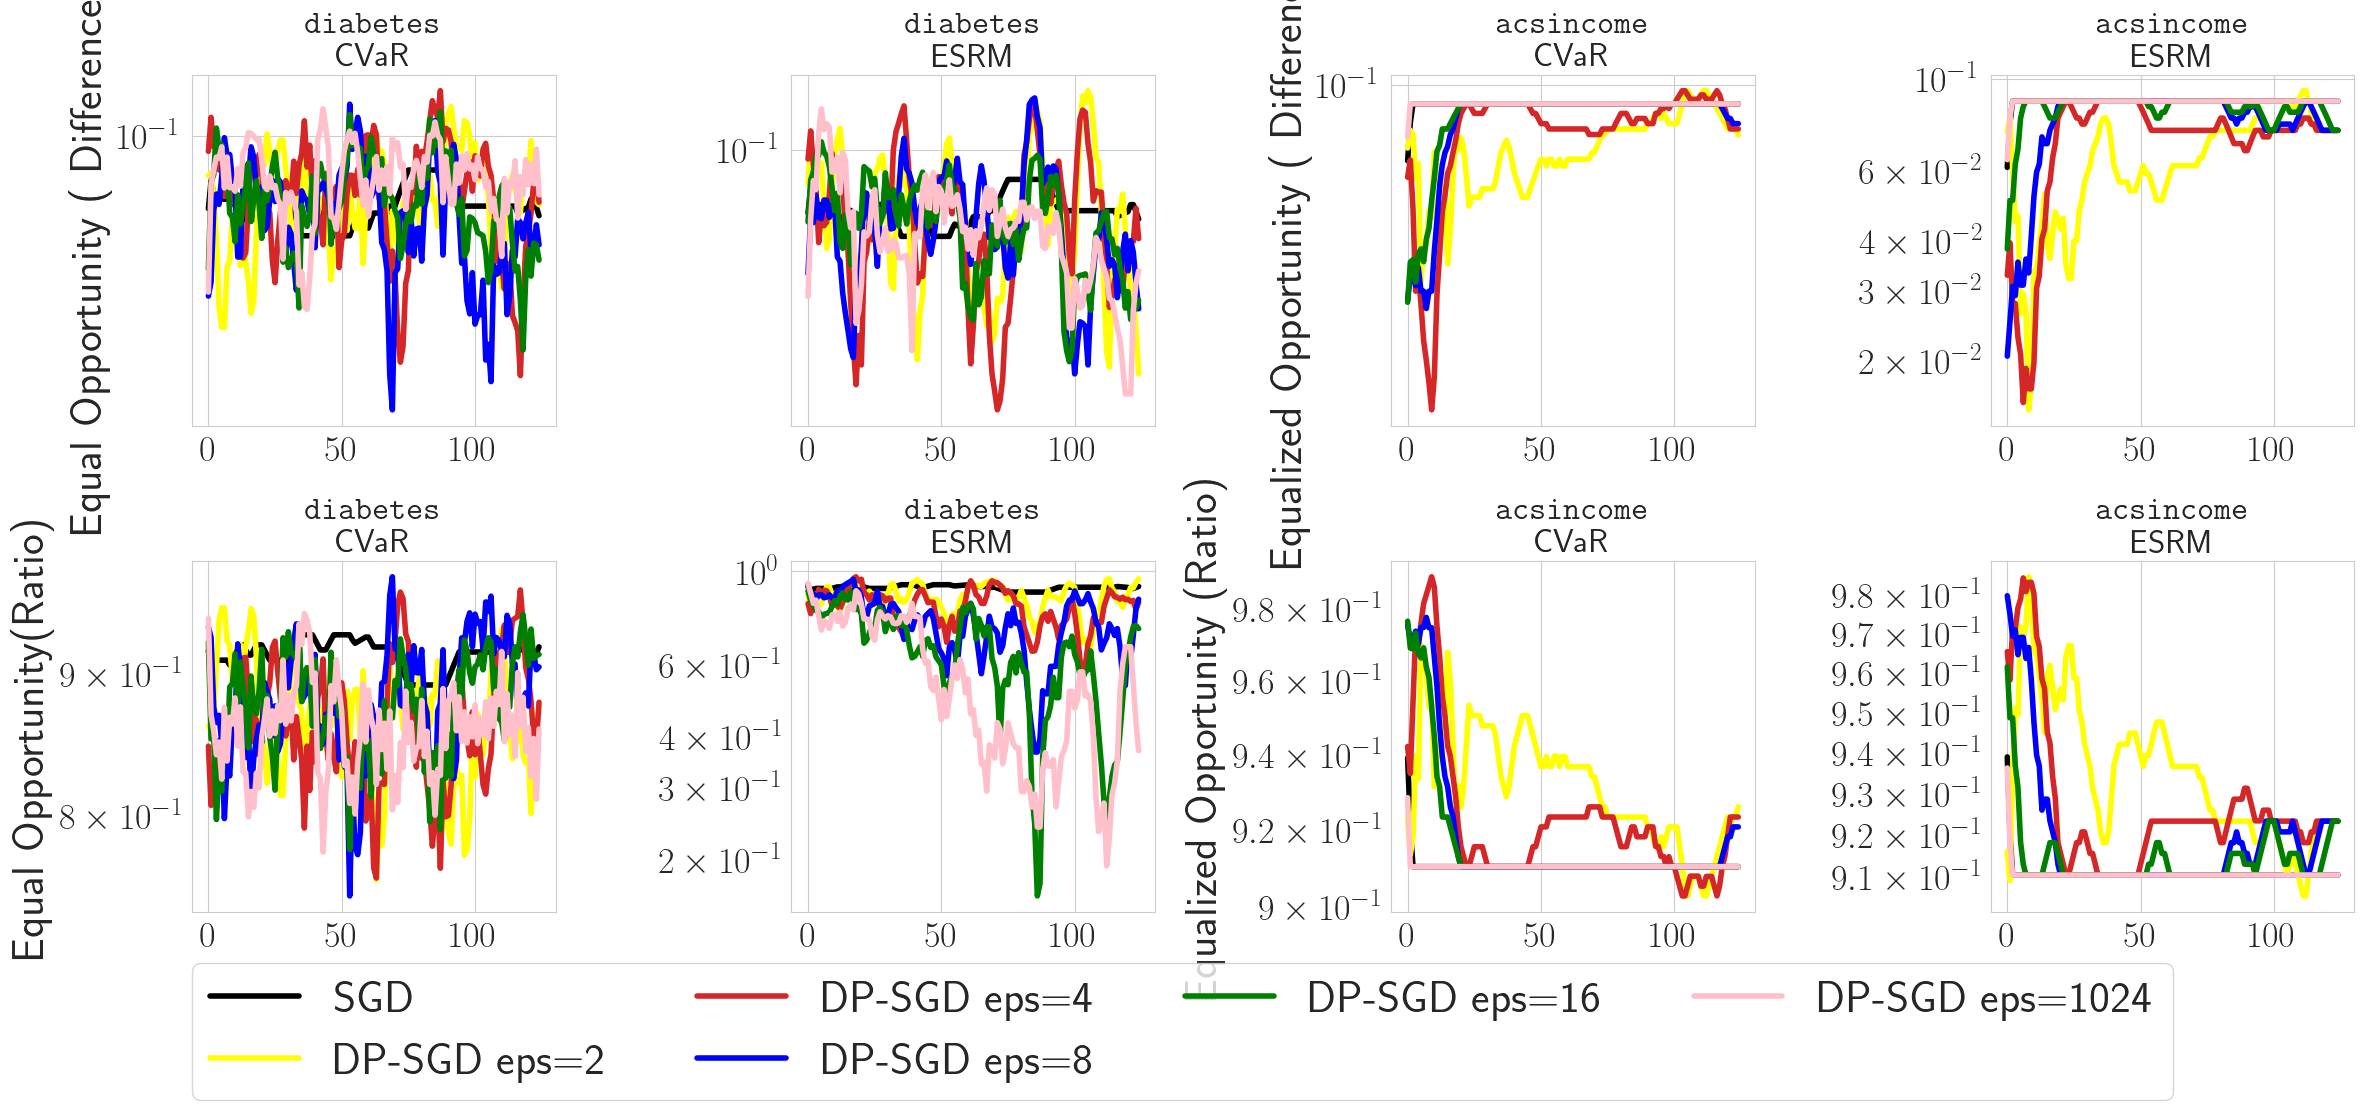

In [26]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "gender"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Equal Opportunity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Equal Opportunity(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "SEX"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Equalized Opportunity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Equalized Opportunity (Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()

Equal Opportunity Race

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 70.46it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 58.20it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 65.34it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 69.34it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 71.97it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 66.40it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 66.89it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 68.46it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 72.02it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 63.38it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 60.91it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 66.63it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 60.04it/s]
/tmp/ipykernel_276947/2918868075.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j].set_yscale("log")


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 71.77it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 71.33it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 71.51it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 70.01it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 72.91it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 62.97it/s]
/tmp/ipykernel_276947/2918868075.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j].set_yscale("log")


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:01, 66.89it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:01, 65.92it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:01, 66.57it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 66.99it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:01, 70.26it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 63.46it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 51.64it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 53.10it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 61.23it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:01, 70.59it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 62.55it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 61.44it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 55.46it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 57.28it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 58.23it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 58.23it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 56.00it/s]


objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 62.90it/s]
/tmp/ipykernel_276947/2918868075.py:115: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j+2].set_yscale("log")


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 55.59it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 55.78it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 52.37it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 57.50it/s]


objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 54.63it/s]


objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 51.58it/s]
/tmp/ipykernel_276947/2918868075.py:115: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1, j+2].set_yscale("log")


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 7.700838411532415}


129it [00:02, 52.65it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:02, 61.21it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.03, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 2.486811256481694}


129it [00:02, 58.13it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 1.53842143427106}


129it [00:02, 48.67it/s]


objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 0.3033901722284405}


129it [00:02, 54.42it/s]
/tmp/ipykernel_276947/2918868075.py:120: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(pad=2.0)


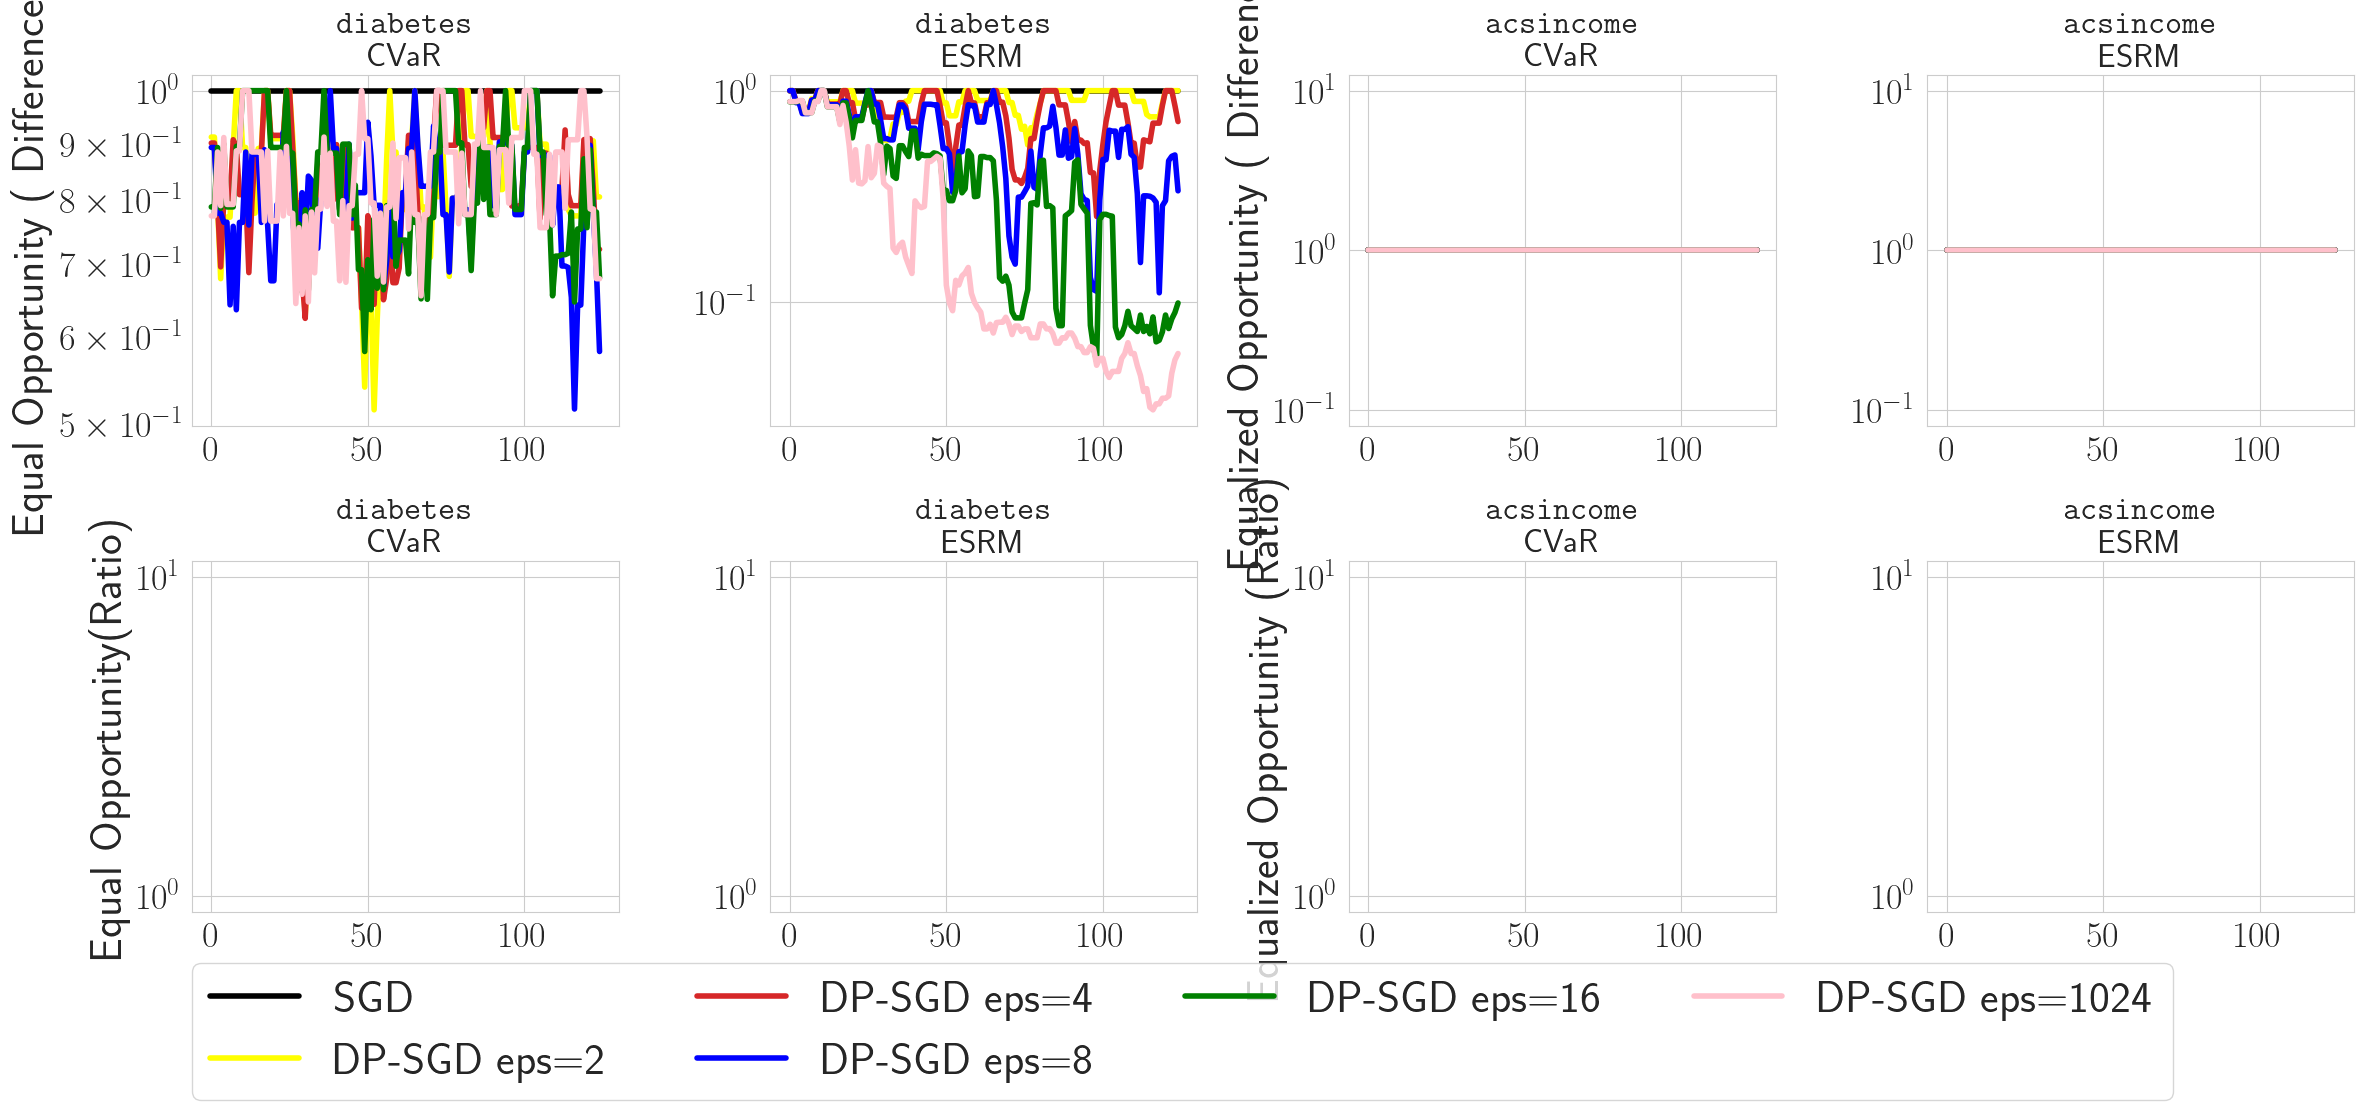

In [27]:
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")

objectives = ["superquantile", "esrm"]
column = "race"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))
metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j].set_yscale("log")

ax[0, 0].set_ylabel(f"Equal Opportunity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[1, j].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j].set_yscale("log")

ax[1, 0].set_ylabel(f"Equal Opportunity(Ratio)", fontsize=32)


###########################################

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()


df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")


objectives = ["superquantile", "esrm"]
column = "RAC1P"

metric = "difference"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))


        markersize = 14
        downsample = 2
        ax[0, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[0, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[0, j+2].set_yscale("log")

ax[0, 2].set_ylabel(f"Equalized Opportunity ( Difference )", fontsize=32)


metric = "ratio"
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")        
        optimizer = plot_cfg["optimizer"]
        yy = get_equalized_opportunity(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, df=df,base_dir=path,metric=metric)
        xx = np.arange(len(yy))
        
        window_size = 5  # You can adjust the window size as needed
        yy_moving_avg = moving_average(yy, window_size)
        xx_moving_avg = np.arange(len(yy_moving_avg))
        markersize = 14
        downsample = 2
        ax[1, j+2].plot(xx_moving_avg, yy_moving_avg, label=plot_cfg['label'], color=plot_cfg['color'])
        ax[1, j+2].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)
        ax[1, j+2].set_yscale("log")

ax[1, 2].set_ylabel(f"Equalized Opportunity (Ratio)", fontsize=32)
 

plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()